Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
Опишите какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
!unzip drive/MyDrive/twitsentanalis.zip

Archive:  drive/MyDrive/twitsentanalis.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
import pandas as pd

df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
max_words = 2000
max_len = 15
num_classes = 1

# Training
epochs = 15
batch_size = 512
print_batch_n = 100

In [5]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Наблюдается выраженный дисбаланс классов. Для наилучшего качества уравняем количество положительных и отрицательных твиттов

In [6]:
df = df[(df.label == 0) & (df.id < 2400) | (df.label == 1)]

In [7]:
df.label.value_counts()

1    2242
0    2232
Name: label, dtype: int64

In [8]:
df_val = df[(df.label == 0) & (df.id > 2100) | (df.label == 1) & (df.id > 28000)]

In [9]:
df_val.label.value_counts()

0    284
1    279
Name: label, dtype: int64

In [10]:
df_train = df[(df.label == 0) & (df.id < 2100) | (df.label == 1) & (df.id < 28000)]

In [11]:
df_train.label.value_counts()

1    1963
0    1947
Name: label, dtype: int64

In [12]:
!pip install stop-words pymorphy2

In [13]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import numpy as np

In [14]:
sw = set(get_stop_words("en"))
# sw

In [15]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [16]:
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [17]:
df_train['tweet'].iloc[19:].values

array(['as we all know, essential oils are not made of chemicals. ',
       '#euro2016 people blaming ha for conceded goal was it fat rooney who gave away free kick knowing bale can hit them from there.  ',
       'sad little dude..   #badday #coneofshame #cats #pissed #funny #laughs ',
       ..., ' destroyed in one minute #janeelliot   ',
       '@user #feminismiscancer #feminismisterrorism #feminismmuktbharat why  #malevote is ignored  @user',
       'mother daughter blowjob  white girl has sex with black guy '],
      dtype=object)

In [18]:
df_train['tweet'].iloc[19:].apply(preprocess_text).values

array(['know essential oils notmade chemicals',
       'euro2016 people blaming ha conceded goal fat rooney gave away free kick knowing bale can hit',
       'sad little dude badday coneofshame cats pissed funny laughs', ...,
       'destroyed one minute janeelliot',
       'user feminismiscancer feminismisterrorism feminismmuktbharat malevote ignored user',
       'mother daughter blowjob white girl sex black guy'], dtype=object)

Лемматизация трейновой и тестовой выборок

In [19]:
from tqdm import tqdm
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 3910/3910 [00:00<00:00, 4104.37it/s]
<ipython-input-19-590fcd0f3cce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
100%|██████████| 563/563 [00:00<00:00, 4453.04it/s]
<ipython-input-19-590fcd0f3cce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)


In [20]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

Произведём токенезацию

In [21]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['user', 'father', 'dysfunctional', 'selfish', 'drags']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [22]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [23]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [24]:
tokens_filtered_top[:10]

['user',
 'amp',
 'love',
 'trump',
 'like',
 'will',
 'just',
 'people',
 'day',
 'happy']

Создадим словарь из токенов

In [25]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'amp': 2,
 'love': 3,
 'trump': 4,
 'like': 5,
 'will': 6,
 'just': 7,
 'people': 8,
 'day': 9,
 'happy': 10,
 'new': 11,
 'libtard': 12,
 'white': 13,
 'black': 14,
 'im': 15,
 'u': 16,
 'dont': 17,
 'can': 18,
 'one': 19,
 'now': 20,
 'get': 21,
 'today': 22,
 'good': 23,
 'time': 24,
 'politics': 25,
 'racist': 26,
 'allahsoil': 27,
 'might': 28,
 'feel': 29,
 'us': 30,
 'thankful': 31,
 'liberal': 32,
 'go': 33,
 'cant': 34,
 'positive': 35,
 'see': 36,
 '2': 37,
 'sjw': 38,
 'women': 39,
 'hate': 40,
 'life': 41,
 'obama': 42,
 'take': 43,
 'listen': 44,
 'retweet': 45,
 'racism': 46,
 'bihday': 47,
 'think': 48,
 'want': 49,
 'never': 50,
 'back': 51,
 'got': 52,
 'america': 53,
 'via': 54,
 'great': 55,
 'work': 56,
 'girl': 57,
 'know': 58,
 'man': 59,
 'right': 60,
 'youre': 61,
 'make': 62,
 'really': 63,
 'say': 64,
 '2016': 65,
 'fathers': 66,
 'way': 67,
 'world': 68,
 'sad': 69,
 'weekend': 70,
 'need': 71,
 'video': 72,
 'stomping': 73,
 'thanks': 74,
 'goin

Перевод текста в последовательности

In [26]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [27]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 931 ms, sys: 7.46 ms, total: 938 ms
Wall time: 1.28 s


In [28]:
x_train.shape

(3910, 15)

In [29]:
df_train['tweet'].iloc[0]

'user father dysfunctional selfish drags kids dysfunction run'

In [30]:
x_train[0]

array([   1,  189, 1611,  272, 1014,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

    def forward(self, x):
        output = self.embedding(x) # B, L, E
        #                       B  E  L
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [32]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [33]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [34]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 15])
torch.Size([512])
tensor(1)


In [35]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [36]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.BCELoss()

In [38]:
model = model.to(device)
model.train()
th = 0.9

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/15]. Step [8/8]. Loss: 0.642. Acc: 0.498. Test loss: 0.480. Test acc: 0.504
Epoch [2/15]. Step [8/8]. Loss: 0.483. Acc: 0.513. Test loss: 0.288. Test acc: 0.575
Epoch [3/15]. Step [8/8]. Loss: 0.367. Acc: 0.642. Test loss: 1.506. Test acc: 0.668
Epoch [4/15]. Step [8/8]. Loss: 0.298. Acc: 0.740. Test loss: 1.700. Test acc: 0.744
Epoch [5/15]. Step [8/8]. Loss: 0.221. Acc: 0.808. Test loss: 0.231. Test acc: 0.732
Epoch [6/15]. Step [8/8]. Loss: 0.172. Acc: 0.853. Test loss: 0.768. Test acc: 0.794
Epoch [7/15]. Step [8/8]. Loss: 0.104. Acc: 0.905. Test loss: 0.037. Test acc: 0.764
Epoch [8/15]. Step [8/8]. Loss: 0.083. Acc: 0.933. Test loss: 0.880. Test acc: 0.805
Epoch [9/15]. Step [8/8]. Loss: 0.052. Acc: 0.961. Test loss: 0.835. Test acc: 0.828
Epoch [10/15]. Step [8/8]. Loss: 0.034. Acc: 0.972. Test loss: 0.294. Test acc: 0.829
Epoch [11/15]. Step [8/8]. Loss: 0.021. Acc: 0.984. Test loss: 0.581. Test acc: 0.822
Epoch [12/15]. Step [8/8]. Loss: 0.014. Acc: 0.987. Test loss: 

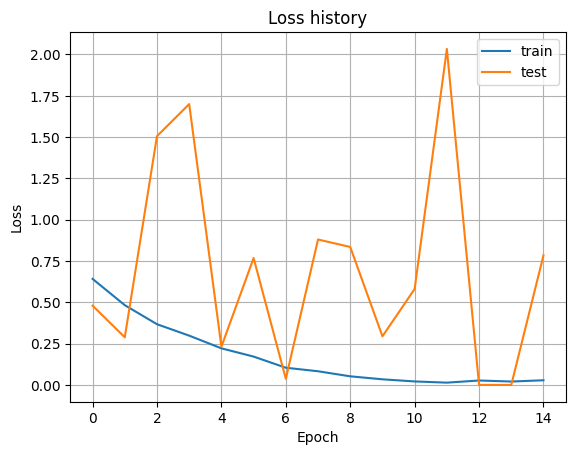

In [39]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

Данные результаты были достигнуты благодаря:
* количество эпох - 15
* скорость обучения - 0,002
* пороговое значения для классификации - 0,9
* максимальное количество токенов в последовательности - 15